#AI - OCR

### Required package

In [ ]:
#!pip instal torch
!pip install EasyOCR
#!pip install opencv-python-headless==4.1.2.30
!pip install --ignore-installed PyYAML
#!pip install attrdict

In [ ]:
# Getting the codes from github repositories.
!git clone https://github.com/aziz-ullah-khan/EasyOCR.git
!git clone https://github.com/Belval/TextRecognitionDataGenerator.git

Checking out files: 100% (252/252), done.
Cloning into 'TextRecognitionDataGenerator'...
remote: Enumerating objects: 1175, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1175 (delta 0), reused 1 (delta 0), pack-reused 1171
Receiving objects: 100% (1175/1175), 135.44 MiB | 12.35 MiB/s, done.
Resolving deltas: 100% (567/567), done.
Checking out files: 100% (275/275), done.


## Collecting/Generating Data

In [ ]:
# Download data using google drive file id
!gdown --id 1Bz78_mC8IOVywJoGRWTGpCqzAaZqUNXV

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Unzip the file- Change the directory according to the training directory
!unzip "/content/jp-dataset.zip" -d '/content/'

In [ ]:
# Changing directory 
%cd /content/TextRecognitionDataGenerator/

# Install required packages
!pip install -r requirements.txt

%cd /content/TextRecognitionDataGenerator/trdg/

# create training samples with count = 100k with wrods = 5, -|---> change directory 
!python run.py -c 1000000 -l ja --output_dir /content/genenerated_data/

In [ ]:
%cd /content/TextRecognitionDataGenerator

/content/TextRecognitionDataGenerator


In [ ]:
# Generate data with manual custom data

from trdg.generators import (
    GeneratorFromDict,
    GeneratorFromRandom,
    GeneratorFromStrings,
    GeneratorFromWikipedia,
)
# ['渥'] contain the required samples, count is total number of samples to generate, lanauge ja = Japanese
generator = GeneratorFromStrings(
    ['A B 1 2 3 4 5 6 7 8 9', 'C D 5 6 7 8', 'T C I - USER technocrea.co.jp', '0 3 0 4 86 23482'],
    count = 500,
    language = 'ja',
)

# saving images
n = 0
for img, lbl in generator:  
  n+=1
  image_name = f"/content/genenerated_data/{lbl}_{n}.jpg"
  img.save(image_name)

### Importing required packages

In [ ]:
#change directory to import train file accessories
%cd /content/EasyOCR/trainer     

/content/EasyOCR/trainer


In [ ]:
import shutil
import os
import pandas as pd
import torch.backends.cudnn as cudnn
import yaml
from train import train
from utils import AttrDict
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow

### Preparing training Data

In [ ]:
# create directories for training and evaluation
%mkdir '/content/EasyOCR/trainer/all_data/ja_train_filtered/'
%mkdir '/content/EasyOCR/trainer/all_data/ja_val/'
%mkdir '/content/processed_images/'

In [ ]:
# initialize directories
BASE_DIR = '/content/1moji-ground-truth/'       # Base directory of the unzip folder
processed_images_dir = '/content/processed_images/'  # directory of final processed images
target_dir_training = '/content/EasyOCR/trainer/all_data/ja_train_filtered/'  
target_dir_val = '/content/EasyOCR/trainer/all_data/ja_val/'
genenerated_data_dir = '/content/genenerated_data'

In [ ]:
training_images_names = []     
training_text_data = []

training_files = os.listdir(BASE_DIR)

for training_file in training_files:
  if training_file.endswith(('.jpg', '.png', 'jpeg', 'tif')):
    image_name_no_extension = training_file.split('.')[0]
    training_text_file = image_name_no_extension + '.gt.txt'
    training_text_file_directory = BASE_DIR + training_text_file
   # print(training_text_file_directory)
    if os.path.isfile(training_text_file_directory):
      with open(training_text_file_directory) as f:
        training_images_names.append(training_file)
        training_text_data.append(f.read())
    else:
      pass
      #print ("text File does not exist!") 

In [ ]:
df_images_text_prepared = pd.DataFrame({'filename': training_images_names,
                  'words': training_text_data    
                   })
df_images_text_prepared.head()

,filename,words
0,yoko010_20211203105710_00003_page_4_character_...,静
1,yoko058_20211203130121_00002_page_2_character_...,建
2,yoko034_20211203115721_00004_page_1_character_...,憎
3,tate069_20220107104816_00012_page_2_character_...,愼
4,tate027_20211203113748_00010_page_2_character_...,殆


In [ ]:
# merging images 
def combine_horizontally(image_names,padding, BASE_DIR):
    images = []
    max_height = 0  # find the max height of all the images
    total_width = 0  # the total width of the images (horizontal stacking)

    for name in image_names:
        # open all images and find their sizes
        img = cv2.imread(BASE_DIR + name)
        height = 32
        width = 32
        dim = (width, height)
        # resize image
        img  = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        images.append(img)

        image_height = img.shape[0]
        image_width = img.shape[1]


        if image_height > max_height:
            max_height = image_height

        # add all the images widths
        total_width += image_width

    # create a new array with a size large enough to contain all the images
    # also add padding size for all the images except the last one
    final_image = np.zeros((max_height, (len(image_names)-1)*padding+ total_width, 3), dtype=np.uint8)

    current_x = 0  # keep track of where your current image was last placed in the x coordinate
    for image in images:
        # add an image to the final array and increment the x coordinate
        height = image.shape[0]
        width = image.shape[1]
        final_image[:height,current_x :width+current_x, :] = image
        #add the padding between the images
        current_x += width+padding

    return final_image

In [ ]:
# random selection of images and text for combination from existing images, [3, 8, 10, 18, ....] 
random_selection = []
processed_images = []
processed_text = []
end_index = len(df_images_text_prepared.index)
idx = 0
start_index = 0
current_index = 0
for itrn in range(end_index):
  rand_idx = random.randint(1,15)
  idx +=rand_idx
  #print(idx)
  random_selection.append(idx)
  if idx > end_index or idx == end_index-1:
    break

for i, itr in enumerate(random_selection):
  if i == 0:
    start_index = 0
    current_index = itr+1
  else:
   # print(f"itrre {itr}")
    start_index = current_index
    current_index = itr+1

  df2 = df_images_text_prepared.iloc[start_index:current_index]
  final_image=combine_horizontally(df2['filename'].values.tolist(),0, BASE_DIR)
  final_text = [' '.join(df2['words'].values.tolist())]
  #cv2_imshow(final_image)
  img_name = processed_images_dir+final_text[0]+'.jpg'
  processed_images.append(img_name)
  processed_text.append(final_text)
  cv2.imwrite(img_name, final_image)

# create data frame
data = pd.DataFrame()
data['filename'] =  processed_images
data['words'] = processed_text


In [ ]:
# generate text from generated images and create df
training_files = os.listdir(genenerated_data_dir)
gen_data = pd.DataFrame(training_files, columns = ['filename'])
gen_data['words'] = gen_data['filename'].str.split(r'_\d+.jpg', expand = True)[0]

In [ ]:
# copy generated images to processed directory
source_dir = genenerated_data_dir
target_dir = processed_images_dir
for file in os.listdir(source_dir):
  shutil.copy2(os.path.join(source_dir, file), target_dir)

In [ ]:
#data = pd.DataFrame()
#data['filename'] = df['filename'].values.tolist() + processed_images
#data['words'] = df['words'].values.tolist() + processed_text

#data.head()

In [ ]:
# combine generated data and processed data
frames = [data, gen_data]
processed_data = pd.concat(frames)

In [ ]:
processed_data = gen_data
processed_images_dir = genenerated_data_dir

Training and Validation Data Preparing

In [ ]:
# spliting data and copy totraining and val dir
training_data, validation_data = train_test_split(processed_data, test_size=0.2)

print('Total files: ', len(processed_data))
print('Total training files: ', len(training_data))
print('Total val files: ', len(validation_data))



for file in training_data['filename']:
  shutil.copy2(os.path.join(processed_images_dir, file), target_dir_training)

for file in validation_data['filename']:
  shutil.copy2(os.path.join(processed_images_dir, file), target_dir_val)

# Save the training data to csv
training_data.to_csv(target_dir_training + 'labels.csv', encoding = 'utf-8', index = False)
validation_data.to_csv(target_dir_val + 'labels.csv', encoding = 'utf-8', index = False)

Total files:  157639
Total training files:  126111
Total val files:  31528


## Training the Model

In [ ]:
cudnn.benchmark = True
cudnn.deterministic = False

In [ ]:
def get_config(file_path):
    with open(file_path, 'r', encoding="utf8") as stream:
        opt = yaml.safe_load(stream)
    opt = AttrDict(opt)
    if opt.lang_char == 'None':
        characters = ''
        for data in opt['select_data'].split('-'):
            csv_path = os.path.join(opt['train_data'], data, 'labels.csv')
            df = pd.read_csv(csv_path, sep=',', engine='python', usecols=['filename', 'words'], keep_default_na=False)
            all_char = ''.join(df['words'])
            characters += ''.join(set(all_char))
        characters = sorted(set(characters))
        opt.character= ''.join(characters)
    else:
        opt.character = opt.number + opt.symbol + opt.lang_char
    os.makedirs(f'./saved_models/{opt.experiment_name}', exist_ok=True)
    return opt


In [ ]:
opt = get_config("config_files/ja_filtered_config.yaml")
train(opt, amp=False)


Filtering the images containing characters which are not in opt.character
Filtering the images whose label is longer than opt.batch_max_length
--------------------------------------------------------------------------------
dataset_root: all_data
opt.select_data: ['ja_train_filtered']
opt.batch_ratio: ['1']
--------------------------------------------------------------------------------
dataset_root:    all_data	 dataset: ja_train_filtered
all_data/ja_train_filtered
sub-directory:	/ja_train_filtered	 num samples: 114109
num total samples of ja_train_filtered: 114109 x 1.0 (total_data_usage_ratio) = 114109
num samples of ja_train_filtered per batch: 32 x 1.0 (batch_ratio) = 32


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------------------------------------------------------------------------
Total_batch_size: 32 = 32
--------------------------------------------------------------------------------
dataset_root:    all_data/ja_val	 dataset: /
all_data/ja_val/
sub-directory:	/.	 num samples: 28496
--------------------------------------------------------------------------------
No Transformation module specified
model input parameters 64 600 20 1 256 256 2287 34 None VGG BiLSTM CTC
Model:
DataParallel(
  (module): Model(
    (FeatureExtraction): VGG_FeatureExtractor(
      (ConvNet): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6):

## Loading the Trained Model

Copy custom_model.py custom_model.yaml  to the root directory: /root/EasyOCR/user_network/

copy custom_model.pth to /root/EasyOCR/model/


In [ ]:
!cp /root/EasyOCR/user_network/custom_model.yaml /root/.EasyOCR/user_network/custom_model.yaml
!cp /root/EasyOCR/user_network/custom_model.py /root/.EasyOCR/user_network/custom_model.py
!cp /root/EasyOCR/model/custom_model.pth /root/.EasyOCR/model/custom_model.pth

In [ ]:
import easyocr
reader = easyocr.Reader(['ja'], recog_network='custom_model')

In [ ]:
image = '/content/telNumber.jpg'

In [ ]:
result = reader.readtext(image)  # remove detail =0 for details.. 
result

[([[506, 33], [2813, 33], [2813, 354], [506, 354]],
  "['3'も'工5'5'毎36乙']",
  0.010307550279302882)]

In [ ]:
!pip install tifffile 
!pip install imagecodecs
!pip install imagecodecs-lite

In [ ]:
def show(result, img):
  spacer = 100
  for detection in result: 
      top_left = tuple(detection[0][0])
      bottom_right = tuple(detection[0][2])
      text = detection[1]
      img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
      img = cv2.putText(img,text,top_left, font, 0.5,(0,0,255),2,cv2.LINE_AA)
      spacer+=15
  plt.figure(figsize=(10,10))
  plt.imshow(img)
  plt.show()


ポイ橋て禁止』
NOLTTB
清潔できれいな港区を
潜 区 MNATOCITY


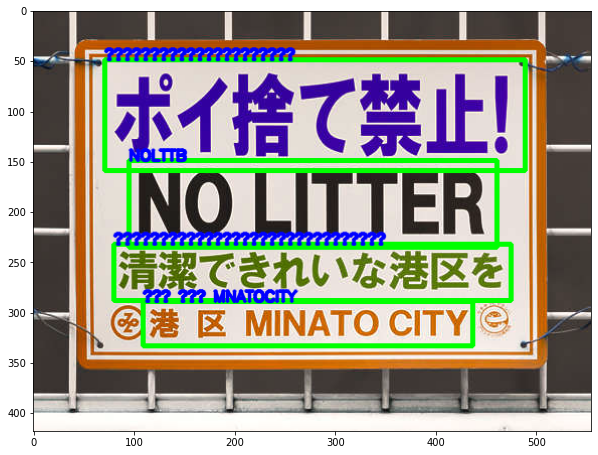

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np


IMAGE_PATH = '/content/japanese.jpg'
#reader = easyocr.Reader(['en'], gpu=False)

img = cv2.imread(IMAGE_PATH)

reader2 = easyocr.Reader(['ja', 'en'])
result = reader2.readtext(IMAGE_PATH)
show(result, img)

result = reader.readtext(IMAGE_PATH)
show(result)



